In [1]:
%matplotlib inline

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from nose.tools import *

from scipy.stats import ttest_ind

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

# Retiring people in Bulgaria

### According to the leaked data from NAP

#### By Kaloyan Zlatkov

## Abstract
In this study, the reader will find detailed analysis of few tables from the leaked data from NAP. The data is about retiring people that have been added to the database of NAP on a single day. There is analysis of their age, gender and salary distribution. There are both expected and unexpected results based on the data. Both men and women tend to delay their retirement for as much as they can. However, it turns out that there is no correlation between people's salary and their gender.

###  Disclaimer
I think that this NAP leakage is outrageous and far from funny so even though I like funny pictures and memes, I don't think that anything like this is appropriate. This data is very, very sad not only because of the data itself, but also when you think that these are real people, who's private data is everywhere on the Internet. Therefore, I am asking the reader not to distribute any private data he might find in this study. I tried to keep the dignity of the people as much as I could and hope that the reader will do the same.

### 1) Definition of hypothesis
My hypothesis is that there is some non-uniform and interesting distribution among the people, their income, their gender, their age in relation to their retirement process. I expect some relation between people's salary and their gender as well as some very narrow distribution around the permitted retiring age (or in other words - the people retire as soon as they can)

### 2) Analysis of retiring people
The law states that there are some conditions regarding the retirement rights of each person, depending on its years of labour service, its age and sex. Each person gets some points (the sum of his/her age and his/her labour service years) and in accordance of his /her gender, he/she has rights to retire or not. Of course, the points may not be enough. For example if the person is working from very early and has huge amount of labour service years, he/she might still not be liable to retire if he/she doesn't have enough age. Because of that one can assume that retirements that are too early should not be a lot and because in our poor country a lot of retired people continue to work even after retirement - there should be some shifting toward more older people, retiring at some point of time (older than those who complete the requirements of the law). Therefore, my prediction is that there will be some highly shifted Gaussian distribution towards older people. If we take for example year 2015, according to the law, the women needed 95.7 points from which 60 years and 8 months age and 35 years labour years. For the men the points are 101.7, with 63 years and 8 months age and 38 years labour years.

### 3) Analysis of the table with the salaries
According to the data from NAP, on 2015-05-18, 17603 retiring people were written down in the database. Here are their monthly incomes/salaries:

In [3]:
retiring_income_data = pd.read_csv("data/MINFIN_BREACH/AEOI/AMOUNT.csv")

In [4]:
retiring_income_data.shape

(17603, 7)

In [5]:
retiring_income_data.dtypes

AMOUNT_ID        int64
CURRENCY_ID      int64
AMOUNT         float64
CREATED_BY      object
CREATED_ON      object
MODIFIED_BY    float64
MODIFIED_ON    float64
dtype: object

In [6]:
retiring_income_data.head()

,AMOUNT_ID,CURRENCY_ID,AMOUNT,CREATED_BY,CREATED_ON,MODIFIED_BY,MODIFIED_ON
0,441,14,1552.98,NSSI_PEN,2015-05-18 16:42:22.000000,NaN,NaN
1,442,14,80.00,NSSI_PEN,2015-05-18 16:42:22.000000,NaN,NaN
2,443,14,1827.00,NSSI_PEN,2015-05-18 16:42:22.000000,NaN,NaN
3,444,14,1473.18,NSSI_PEN,2015-05-18 16:42:22.000000,NaN,NaN
4,445,14,60.00,NSSI_PEN,2015-05-18 16:42:22.000000,NaN,NaN


From all these columns the interesting ones are: 
- AMOUNT_ID - this will be the connection between this table and the other ones, maybе getting the real names and other information about these people. I will rename it as "amount_id"
- AMOUNT - it is not specified what amount that might be (as there is not column information in the leaked data obviously) but my guess is that this is the amount of monthly income (the official income, over which the pension and health payments were made). Usually this income is the last salary of the person, so I will rename it as "salary"
- CURRENCY_ID - this is obviously the currency of the described salary. I will check how many currencies are there:

In [7]:
retiring_income_data.CURRENCY_ID.unique()

array([14], dtype=int64)

It seems that there is only one currency in this table with CURRENCY_ID == 14. The chances that this is not BGN is very low, but I will check in one of the other tables, named "CURRENCY":

In [8]:
currencies_data = pd.read_csv("data/MINFIN_BREACH/AEOI/CURRENCY.csv")

In [9]:
currencies_data.head()

,CURRENCY_ID,CODE,CREATED_BY,CREATED_ON,MODIFIED_BY,MODIFIED_ON
0,1,AED,init,2014-11-07 09:16:51.000000,init,2014-11-07 09:16:51.000000
1,2,AFN,init,2014-11-07 09:16:51.000000,init,2014-11-07 09:16:51.000000
2,3,ALL,init,2014-11-07 09:16:51.000000,init,2014-11-07 09:16:51.000000
3,4,AMD,init,2014-11-07 09:16:51.000000,init,2014-11-07 09:16:51.000000
4,5,ANG,init,2014-11-07 09:16:51.000000,init,2014-11-07 09:16:51.000000


In [10]:
currencies_data[currencies_data['CURRENCY_ID'] == 14]

,CURRENCY_ID,CODE,CREATED_BY,CREATED_ON,MODIFIED_BY,MODIFIED_ON
13,14,BGN,init,2014-11-07 09:16:51.000000,init,2014-11-07 09:16:51.000000


After I confirmed that the currency is BGN and that there are not any other currencies, I will remove the CURRENCY_ID column and just rename the AMOUNT column "salary_BGN". In addition, the rest of the columns (CREATED_BY, CREATED_ON, MODIFIED_BY, MODIFIED_ON) are not interesting for me (the modified date is the same as the created date, the MODIFIED_BY column is full only of NaN

In [11]:
retiring_income_data.CREATED_BY.unique()

array(['NSSI_PEN'], dtype=object)

In [12]:
retiring_income_data.MODIFIED_BY.unique()

array([nan])

In [13]:
retiring_income_data_renamed = retiring_income_data.drop(['CURRENCY_ID', 'CREATED_BY', 'MODIFIED_BY', 'MODIFIED_ON'], axis=1)

In [14]:
retiring_income_data_renamed.columns = ["amount_id", "salary_BGN", "created_on"]

In [15]:
retiring_income_data_renamed.head()

,amount_id,salary_BGN,created_on
0,441,1552.98,2015-05-18 16:42:22.000000
1,442,80.00,2015-05-18 16:42:22.000000
2,443,1827.00,2015-05-18 16:42:22.000000
3,444,1473.18,2015-05-18 16:42:22.000000
4,445,60.00,2015-05-18 16:42:22.000000


In [16]:
retiring_income_data_renamed.isna().any()

amount_id     False
salary_BGN    False
created_on    False
dtype: bool

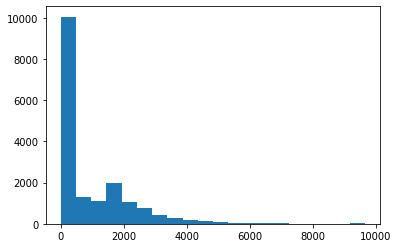

In [17]:
plt.hist(retiring_income_data_renamed.salary_BGN, bins = 20)
plt.show()

It is clear and expected - that the income of the retiring people in Bulgaria is very low and that the poor people are majority :( 

OK now I will leave this table and look at the next one

### 4) Analysis of the table with the EGNs
According to NAP the same 17603 retired people have the following additional data:

In [18]:
pension_recipients = pd.read_csv("data/MINFIN_BREACH/AEOI/PEN_RECIPIENT.csv")

In [19]:
pension_recipients.shape

(17603, 12)

In [20]:
pension_recipients.head()

,DOCREFID,MESSAGE_ID,CORRDOCREFID,PEN_RECIPIENT_ID,NATURAL_PERSON_ID,REPRESENTATIVE_ID,CREATED_BY,CREATED_ON,MODIFIED_BY,MODIFIED_ON,RECIPIENT_NUMBER,INFORMATION_STATUS
0,PEN_NSSI2014-12-31536,203,NaN,203,203,NaN,NSSI_PEN,2015-05-18 16:42:19.000000,NaN,NaN,3201034369,new
1,PEN_NSSI2014-12-31537,204,NaN,204,204,NaN,NSSI_PEN,2015-05-18 16:42:19.000000,NaN,NaN,4807314376,new
2,PEN_NSSI2014-12-31538,205,NaN,205,205,NaN,NSSI_PEN,2015-05-18 16:42:19.000000,NaN,NaN,4807314376,new
3,PEN_NSSI2014-12-31539,206,NaN,206,206,NaN,NSSI_PEN,2015-05-18 16:42:19.000000,NaN,NaN,4807314376,new
4,PEN_NSSI2014-12-31540,207,NaN,207,207,NaN,NSSI_PEN,2015-05-18 16:42:19.000000,NaN,NaN,3606184474,new


In [21]:
pension_recipients.dtypes

DOCREFID               object
MESSAGE_ID              int64
CORRDOCREFID          float64
PEN_RECIPIENT_ID        int64
NATURAL_PERSON_ID       int64
REPRESENTATIVE_ID     float64
CREATED_BY             object
CREATED_ON             object
MODIFIED_BY           float64
MODIFIED_ON           float64
RECIPIENT_NUMBER        int64
INFORMATION_STATUS     object
dtype: object

In [22]:
pension_recipients.isna().any()

DOCREFID              False
MESSAGE_ID            False
CORRDOCREFID           True
PEN_RECIPIENT_ID      False
NATURAL_PERSON_ID     False
REPRESENTATIVE_ID      True
CREATED_BY            False
CREATED_ON            False
MODIFIED_BY            True
MODIFIED_ON            True
RECIPIENT_NUMBER      False
INFORMATION_STATUS    False
dtype: bool

In [23]:
pension_recipients.CORRDOCREFID.unique()

array([nan])

In [24]:
pension_recipients.REPRESENTATIVE_ID.unique()

array([nan])

In [25]:
pension_recipients.MODIFIED_BY.unique()

array([nan])

In [26]:
pension_recipients.MODIFIED_ON.unique()

array([nan])

In [27]:
pension_recipients.INFORMATION_STATUS.unique()

array(['new'], dtype=object)

In [28]:
pension_recipients.CREATED_BY.unique()

array(['NSSI_PEN'], dtype=object)

It seems that many of the columns are either full with NaN values only or with just a single value which is not relevant to our study. In addition, I will not use the column DOCREFID as I don't have access to the docs send. Also the columns MESSAGE_ID, PEN_RECIPIENT_ID and NATURAL_PERSON_ID are with the same value and can be combined into one feature:

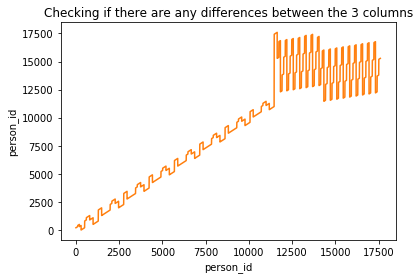

In [29]:
plt.plot(pension_recipients.NATURAL_PERSON_ID, pension_recipients.REPRESENTATIVE_ID, pension_recipients.MESSAGE_ID)
plt.title("Checking if there are any differences between the 3 columns")
plt.xlabel("person_id")
plt.ylabel("person_id")
plt.show()

In [30]:
pension_recipients_renamed = pension_recipients.drop(['MESSAGE_ID', 'DOCREFID', 'CORRDOCREFID', 'NATURAL_PERSON_ID', 'REPRESENTATIVE_ID', 'CREATED_BY', 'MODIFIED_BY', 'MODIFIED_ON', 'INFORMATION_STATUS'], axis=1)

In [31]:
pension_recipients_renamed.columns

Index(['PEN_RECIPIENT_ID', 'CREATED_ON', 'RECIPIENT_NUMBER'], dtype='object')

In [32]:
pension_recipients_renamed.columns = ["retiring_person_id", "created_on", "EGN"]

In [33]:
pension_recipients_renamed.head()

,retiring_person_id,created_on,EGN
0,203,2015-05-18 16:42:19.000000,3201034369
1,204,2015-05-18 16:42:19.000000,4807314376
2,205,2015-05-18 16:42:19.000000,4807314376
3,206,2015-05-18 16:42:19.000000,4807314376
4,207,2015-05-18 16:42:19.000000,3606184474


According to the laws and rules in Bulgaria regarding the citizen's unique id number (the so called EGN) the numbers are formulated like this:
- the first 2 digits are the year of birth. Both 1900 and 2000 are with digits 00
- the 3rd and 4th digits are the month of birth. If you're born before 1st of January 1900, the number 20 is added to your month digits (i.e. if you're born on April 1890, you get 9025 as starting 4 digits of your EGN). If you're born after 31th of Deceber 1999, the number 40 is added to your month digits (i.e. if you're born on April 2008, you get 0845 as starting 4 digits of your EGN))
- the 5th and the 6th digits are the day of birth.
- the 7th, 8th and 9th digits are holding information about the region in Bulgaria where the birth took place. The 7th and the 8th digits are randomly generated and the 9th digit is even for boys and odd for girls.
- the last 10th number is "control number" and is calculated following this algorithm:
    - there is a weighted number for each 9 positions previously explained. Each of this weighted number is multiplied with the number of a concrete person (on the concrete positions). The result is divided by 11 and the remainder is taken (like n % 11 in most coding languages). If the result is < 10, it is taken as a control number; otherwise, the number 0 is taken. Because I'm working with real people's data and EGN I feel morally obligated to test and demonstrate this number with my own EGN, which is 8504027065:

| Position | Weight | My EGN numbers | Multiplication result |
|----------|--------|----------------|-----------------------|
| 1        | 2      | 8              | 16                    |
| 2        | 4      | 5              | 20                    |
| 3        | 8      | 0              | 0                     |
| 4        | 5      | 4              | 20                    |
| 5        | 10     | 0              | 0                     |
| 6        | 9      | 2              | 18                    |
| 7        | 7      | 7              | 49                    |
| 8        | 3      | 0              | 0                     |
| 9        | 6      | 6              | 36                    |

        The sum is 159 and:

In [34]:
159 % 11

5

Moreover, it turns out that my EGN in relation to this algorithm is correct, thanks god! In addition, there are strange EGN values as min and max. Maybe the max value is for some kid with health problems that gets some pension - I don't have any other explanation. Regarding the min value - it is some mistake in my opinion - there cannot be 6-digit EGNs:

In [35]:
pension_recipients_renamed.EGN.max()

9911264386

In [36]:
pension_recipients_renamed.EGN.min()

171171

In [37]:
pension_recipients_renamed.EGN.mean()

4600648945.152133

In [38]:
pension_recipients_renamed.EGN.median()

4610176249.0

In [39]:
pension_recipients_renamed.EGN.mode()

0    4001160079
dtype: int64

In [40]:
pension_recipients_renamed.EGN.skew()

0.5181221263498235

In [41]:
def show_histogram(dataframe, column, binZ):
    plt.figure(figsize = (12, 6))
    plt.hist(dataframe[column], bins = binZ)
    plt.title("{} distribution amongst the retired people on 18.05.2015".format(column))
    plt.xlabel("{} as a real number".format(column))
    plt.ylabel("Count")
    plt.show()

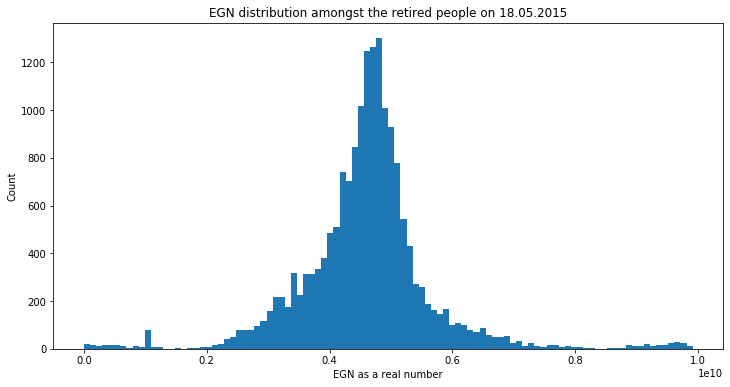

In [42]:
show_histogram(pension_recipients_renamed, "EGN", 100)

The results are very interesting for me.
- First: there are obviously more wrong data in the left part of the distribution (EGNs with number of digits < 10) I will try to filter them
- Second: there are some pensions for very young people (with EGN starting with 90) - maybe I have to make further investigation on that fact
- Third: there is very small skew and this distribution is very close to normal distribution.
- I never thought before but actually, the left shift is very logical. The people to the right are maybe people from category 1 and 2 that can retire at much younger age. There are some but not so far away. On the left side however there are much more people. This means that people, much older than 60/63 years old have made a decision for late retirement (later than their age requirement). This could be because they were missing points (they had the age but were missing the labour service years) OR they have the points and everything but just decided not to retire and continue working for much higher income. We can check this second theory by looking at the income from the first table and making connection between the two tables.

However, before mixing tables I will try to extract the gender and make some function for birth year extraction as well as it is the most relevant for me. I plan to ignore the rest of the EGN data later on

In [43]:
MINIMUM_EGN_VALUE = 1000000000

In [44]:
pension_recipients_filtered = pension_recipients_renamed.loc[pension_recipients_renamed.EGN >= MINIMUM_EGN_VALUE]

In [45]:
pension_recipients_renamed.shape

(17603, 3)

In [46]:
pension_recipients_filtered.shape

(17475, 3)

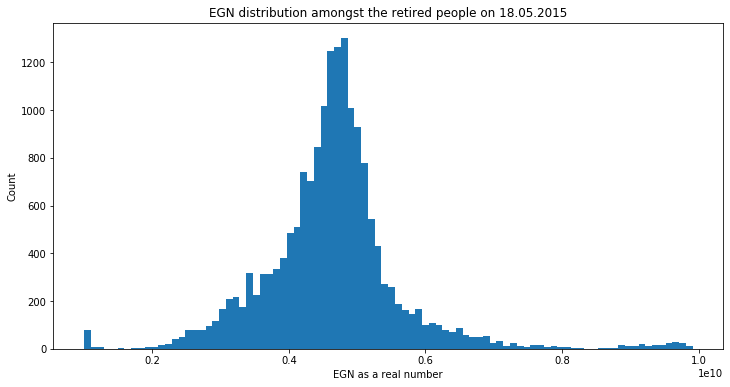

In [47]:
show_histogram(pension_recipients_filtered, "EGN", 90)

In [48]:
filtered_data = 100 * (pension_recipients_renamed.shape[0] - pension_recipients_filtered.shape[0]) / pension_recipients_renamed.shape[0]
print("The deleted data by filtered wrong EGNs is {:.2f}%".format(filtered_data))

The deleted data by filtered wrong EGNs is 0.73%


Ok, after filtering the wrong data we can take a closer look at the younger people (I will take the threshold 80's because this means 35 years in 2015, maybe reasonable for some miners or other people with category 1):

In [49]:
THRESHOLD_FOR_RIGHT_OUTLIERS = 8000000000
young_retired_people = pension_recipients_filtered[pension_recipients_filtered.EGN > THRESHOLD_FOR_RIGHT_OUTLIERS]
retired_with_regular_age = pension_recipients_filtered[pension_recipients_filtered.EGN <= THRESHOLD_FOR_RIGHT_OUTLIERS]

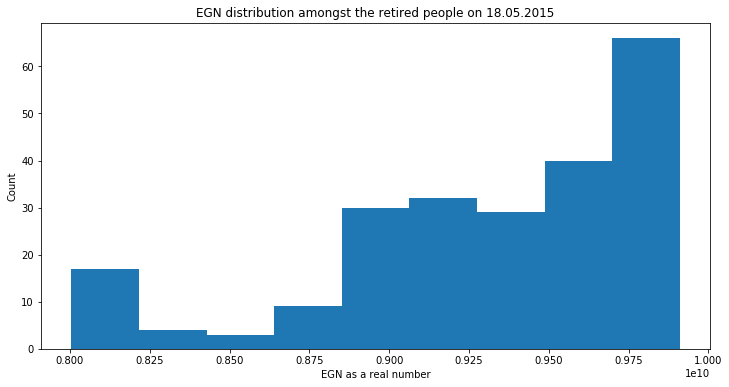

In [50]:
show_histogram(young_retired_people, "EGN", 'fd')

In [51]:
pension_recipients_renamed[pension_recipients_renamed.EGN <= MINIMUM_EGN_VALUE].shape

(128, 3)

So my theory is that these 128 entries with EGN with number of digits < 10 are not incorrect, but are rather with leading zeroes (and from NAP did not take adequate decision making the EGN values int64 and losing these leading digits). So I will try to modify the EGN column by leaving only years

In [52]:
def calculate_year(EGN, century):
    return century + np.floor(EGN / 100000000)

In [53]:
def get_year_from_EGN(EGN):
    months = np.floor(EGN / 1000000) % 100
    if months < 20:
        year = calculate_year(EGN, 1900)
    elif months > 40:
        year = calculate_year(EGN, 2000)
    else:
        year = calculate_year(EGN, 1800)
    return year

In [54]:
assert_equal(1985, get_year_from_EGN(8504027065))
assert_equal(1885, get_year_from_EGN(8524027065))
assert_equal(2085, get_year_from_EGN(8544027065))
assert_equal(1905, get_year_from_EGN(510027065))
assert_equal(1805, get_year_from_EGN(530027065))
assert_equal(2005, get_year_from_EGN(550027065))
assert_equal(1900, get_year_from_EGN(10027065))
assert_equal(1900, get_year_from_EGN(4027065))
assert_equal(2000, get_year_from_EGN(44027065))

It seems that I have mistaken and these 128 entries are correct and valid EGNs but with bad interpretation (mainly lost leading zeroes). 

In [55]:
pension_recipients_cleaned = pension_recipients_renamed

In [56]:
pension_recipients_cleaned.EGN = pension_recipients_cleaned.EGN.apply(lambda x: get_year_from_EGN(x))

In [57]:
pension_recipients_cleaned.rename(columns={'EGN':'birth_year'}, inplace=True)

In [58]:
pension_recipients_cleaned.head()

,retiring_person_id,created_on,birth_year
0,203,2015-05-18 16:42:19.000000,1932.0
1,204,2015-05-18 16:42:19.000000,1948.0
2,205,2015-05-18 16:42:19.000000,1948.0
3,206,2015-05-18 16:42:19.000000,1948.0
4,207,2015-05-18 16:42:19.000000,1936.0


In [59]:
pension_recipients_cleaned.shape

(17603, 3)

In [60]:
pension_recipients_cleaned.dtypes

retiring_person_id      int64
created_on             object
birth_year            float64
dtype: object

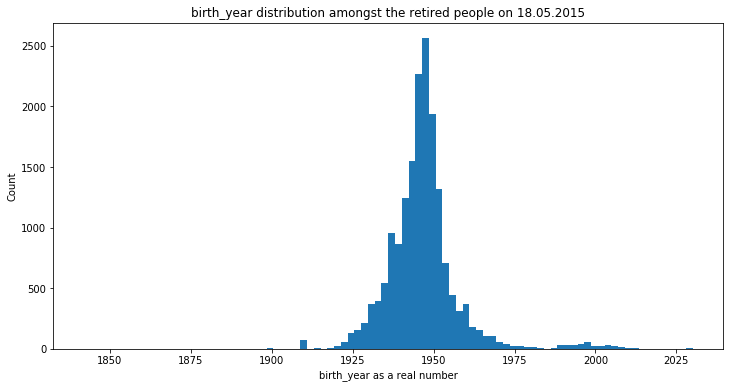

In [61]:
show_histogram(pension_recipients_cleaned, "birth_year", 90)

In [62]:
pension_recipients_cleaned.birth_year.max()

2030.0

In [63]:
pension_recipients_cleaned.birth_year.min()

1842.0

In [64]:
pension_recipients_cleaned.birth_year.mean()

1946.755609839232

In [65]:
pension_recipients_cleaned.birth_year.median()

1946.0

In [66]:
pension_recipients_cleaned.birth_year.mode()

0    1948.0
dtype: float64

In [67]:
pension_recipients_cleaned.birth_year.skew()

1.679749984479715

In [68]:
THRESHOLD_FOR_RIGHT_OUTLIERS = 1980
THRESHOLD_FOR_LEFT_OUTLIERS = 1915
regular_age = (pension_recipients_cleaned.birth_year <= THRESHOLD_FOR_RIGHT_OUTLIERS) & (pension_recipients_cleaned.birth_year >= THRESHOLD_FOR_LEFT_OUTLIERS)
young_retired_people = pension_recipients_cleaned[pension_recipients_cleaned.birth_year > THRESHOLD_FOR_RIGHT_OUTLIERS]
retired_with_regular_age = pension_recipients_cleaned[regular_age]
old_retired_people = pension_recipients_cleaned[pension_recipients_cleaned.birth_year < THRESHOLD_FOR_LEFT_OUTLIERS]

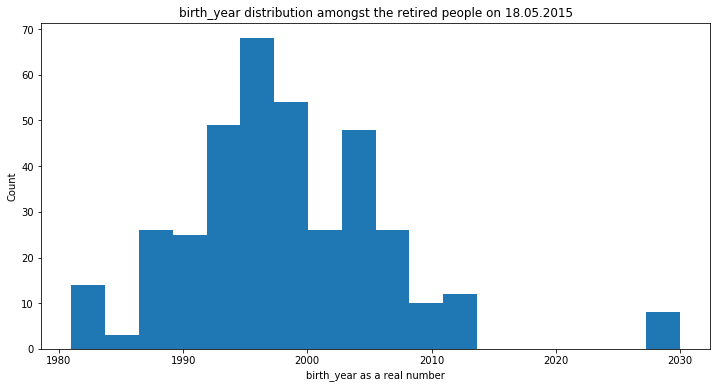

In [69]:
show_histogram(young_retired_people, "birth_year", 'fd')

Therefore, as I have suspected, there is a secondary distribution with normal distribution around year 1998. What does that date means? Maybe the fact that 2015 (the year of this data) minus 1998 == 17. I.e. maybe this maximum is related to the children that enter adulthood (become 18 years old) and get their social/illness retirement as soon as they can. Maybe before that their parents took for them these social payments. Nevertheless, if that is the case - I have no explanation why there are people with age less than 18.

I cannot stop thinking that there might be also another explanation. The people born in the end of the Communist regime and in the following years of the transition towards the democracy are a total minority. I cannot find any reason why there is such a drop in the retiring people in between these years. Maybe they are too young to get regular pension and too old to start taking social/illness pension yet. Or maybe the raw reality of the transition towards the democracy made them expect less from the social system of the country? This is a research on its own and is out of the scope of this study. However, I will compare this result with some data about the total births in Bulgaria during that period looking for some correlation

In [70]:
young_retired_people.mean()

retiring_person_id    11063.867209
birth_year             1998.308943
dtype: float64

Of course, there are some wrong data like the years 1842 and 2030 but maybe they are the result of bad birth year parsing from the EGN or just wrong EGN data

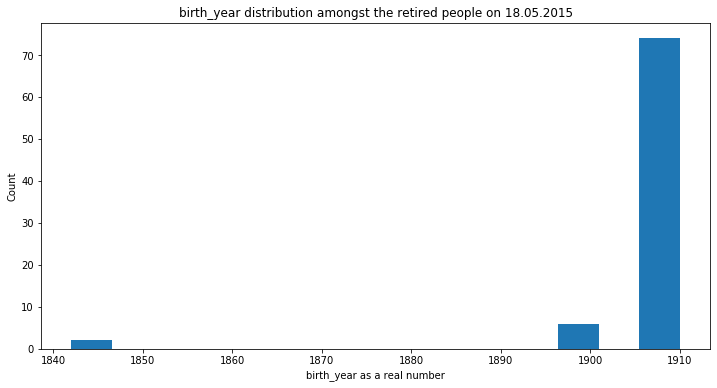

In [71]:
show_histogram(old_retired_people, "birth_year", 15)

So the people 100 and more years old are quite suspicious, especially those 70+ that are 

In [72]:
pension_recipients_renamed = pension_recipients.drop(['MESSAGE_ID', 'DOCREFID', 'CORRDOCREFID', 'NATURAL_PERSON_ID', 'REPRESENTATIVE_ID', 'CREATED_BY', 'MODIFIED_BY', 'MODIFIED_ON', 'INFORMATION_STATUS'], axis=1)
pension_recipients_renamed.columns = ["retiring_person_id", "created_on", "EGN"]

In [73]:
old_retired_people_egn = pd.merge(old_retired_people, pension_recipients_renamed, left_index=True, right_index=True)

In [74]:
old_retired_people_egn.head()

,retiring_person_id_x,created_on_x,birth_year,retiring_person_id_y,created_on_y,EGN
3397,3202,2015-05-18 16:42:58.000000,1910.0,3202,2015-05-18 16:42:58.000000,1000268793
3398,3203,2015-05-18 16:42:58.000000,1910.0,3203,2015-05-18 16:42:58.000000,1000268793
4421,4912,2015-05-18 16:44:59.000000,1910.0,4912,2015-05-18 16:44:59.000000,1001774600
4422,4913,2015-05-18 16:44:59.000000,1910.0,4913,2015-05-18 16:44:59.000000,1001774600
4748,4555,2015-05-18 16:43:40.000000,1910.0,4555,2015-05-18 16:43:40.000000,1001123875


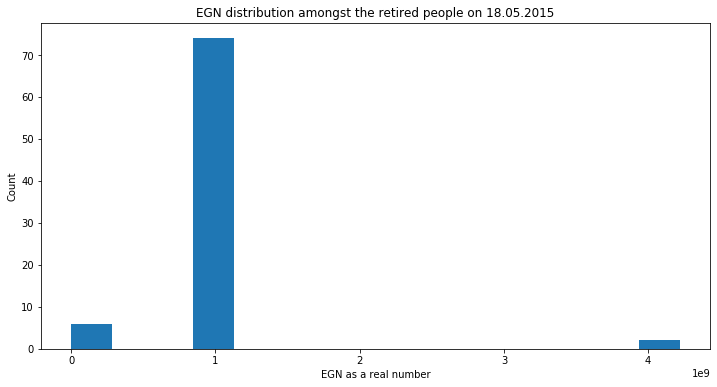

In [75]:
show_histogram(old_retired_people_egn, "EGN", 15)

As it seems that these EGNs are correctly calculated I will just ignore them.

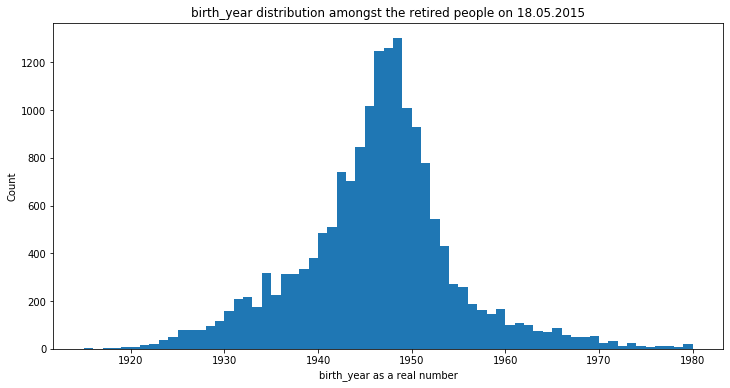

In [76]:
show_histogram(retired_with_regular_age, "birth_year", 65)

In [77]:
def print_stat_data(dataframe, message):
    regular_max = dataframe.birth_year.max()
    regular_min = dataframe.birth_year.min()
    regular_mean = dataframe.birth_year.mean()
    regular_median = dataframe.birth_year.median()
    regular_mode = dataframe.birth_year.mode()
    regular_skew = dataframe.birth_year.skew()
    print("For the {}, the data is: max = {}, min = {}, mean = {}, median = {}, mode = {}, skew = {}"
      .format(message, regular_max, regular_min, regular_mean, regular_median, regular_mode, regular_skew))

In [78]:
print_stat_data(retired_with_regular_age, "people with regular age")

For the people with regular age, the data is: max = 1980.0, min = 1915.0, mean = 1945.8336637126865, median = 1946.0, mode = 0    1948.0
dtype: float64, skew = 0.1360776311658835


Obviously, this is something very close to Gaussian distribution with small skew to the left. The mean is 1945, the median is 1946 and the mode is 1948. The theoretical age for people who retire as soon as they complete their age requirement are 2015-60 = 1955 for women and 2015-63 = 1953 for men. Therefore, it seems that most of the people retire at actually much older age - between 67 and 70 years old. Of course, it is very strange 17 hundred people to go and retire on the same date and maybe these are accumulated for some time and a officer from NAP just filled the database with them on that date - we'll never know. Nevertheless, as I see my colleagues in my work and the fact that almost all of them try to work and delay retiring as much as they can and the fact that most of them retire at age of 70 I think that there is no shifting in this data.

It will be good if the men are separated from the women, as there could be interesting differences. As we already know, the women are with EGNs with odd 9th number, and the men with even 9th number:

In [79]:
def define_is_man(EGN):
    nine_num = np.floor(EGN / 10) % 2 == 0
    return nine_num

In [80]:
assert_equal(True, define_is_man(8504027065))
assert_equal(False, define_is_man(8504027015))

In [81]:
retired_with_regular_age_egn = pd.merge(retired_with_regular_age, pension_recipients_renamed, left_index=True, right_index=True)

In [82]:
retired_with_regular_age_egn = retired_with_regular_age_egn.drop(['created_on_y', 'retiring_person_id_y'], axis=1)

In [83]:
retired_with_regular_age_egn.columns = ["retiring_person_id", "created_on", "birth_year", "male"]

In [84]:
retired_with_regular_age_egn.head()

,retiring_person_id,created_on,birth_year,male
0,203,2015-05-18 16:42:19.000000,1932.0,3201034369
1,204,2015-05-18 16:42:19.000000,1948.0,4807314376
2,205,2015-05-18 16:42:19.000000,1948.0,4807314376
3,206,2015-05-18 16:42:19.000000,1948.0,4807314376
4,207,2015-05-18 16:42:19.000000,1936.0,3606184474


In [85]:
retired_with_regular_age_egn.shape

(17152, 4)

In [86]:
retired_with_regular_age_egn.male = retired_with_regular_age_egn.male.apply(lambda x: define_is_man(x))

In [87]:
retired_with_regular_age_egn.dtypes

retiring_person_id      int64
created_on             object
birth_year            float64
male                     bool
dtype: object

In [88]:
retired_with_regular_age_egn.head()

,retiring_person_id,created_on,birth_year,male
0,203,2015-05-18 16:42:19.000000,1932.0,True
1,204,2015-05-18 16:42:19.000000,1948.0,False
2,205,2015-05-18 16:42:19.000000,1948.0,False
3,206,2015-05-18 16:42:19.000000,1948.0,False
4,207,2015-05-18 16:42:19.000000,1936.0,False


In [89]:
retired_with_regular_age_egn.shape

(17152, 4)

In [90]:
retired_with_regular_age_male = retired_with_regular_age_egn[retired_with_regular_age_egn.male]
retired_with_regular_age_female = retired_with_regular_age_egn[~retired_with_regular_age_egn.male]

In [91]:
retired_with_regular_age_female.shape

(10748, 4)

In [92]:
retired_with_regular_age_male.shape

(6404, 4)

It turns out that there are 6404 men and 10748 women.

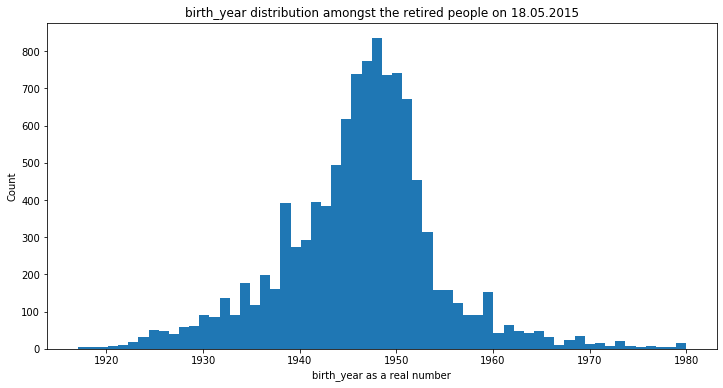

In [93]:
show_histogram(retired_with_regular_age_female, "birth_year", 60)

In [94]:
print_stat_data(retired_with_regular_age_female, "women with regular age")

For the women with regular age, the data is: max = 1980.0, min = 1917.0, mean = 1946.3231298846297, median = 1947.0, mode = 0    1948.0
dtype: float64, skew = 0.030993121398071404


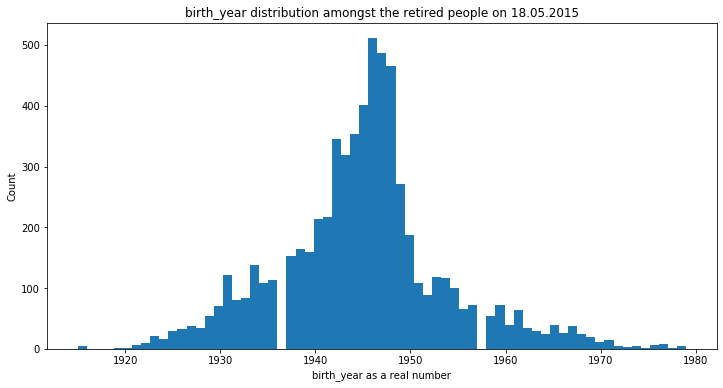

In [95]:
show_histogram(retired_with_regular_age_male, "birth_year", 'fd')

In [96]:
print_stat_data(retired_with_regular_age_male, "men with regular age")

For the men with regular age, the data is: max = 1979.0, min = 1915.0, mean = 1945.0121798875703, median = 1945.0, mode = 0    1946.0
dtype: float64, skew = 0.31874766919950215


Therefore, the difference between men and women is expected - the men are 1-2 years older than the women when they retire

### 5) Combining the table with the EGN and age and the table with salaries
Now I will merge the two columns 

In [97]:
retired_with_regular_age_salary = pd.merge(retired_with_regular_age_egn, retiring_income_data_renamed, left_index=True, right_index=True)

In [98]:
retired_with_regular_age_salary.head()

,retiring_person_id,created_on_x,birth_year,male,amount_id,salary_BGN,created_on_y
0,203,2015-05-18 16:42:19.000000,1932.0,True,441,1552.98,2015-05-18 16:42:22.000000
1,204,2015-05-18 16:42:19.000000,1948.0,False,442,80.00,2015-05-18 16:42:22.000000
2,205,2015-05-18 16:42:19.000000,1948.0,False,443,1827.00,2015-05-18 16:42:22.000000
3,206,2015-05-18 16:42:19.000000,1948.0,False,444,1473.18,2015-05-18 16:42:22.000000
4,207,2015-05-18 16:42:19.000000,1936.0,False,445,60.00,2015-05-18 16:42:22.000000


In [99]:
retired_with_regular_age_salary = retired_with_regular_age_salary.drop(['created_on_y', 'amount_id'], axis=1)

In [100]:
retired_with_regular_age_salary.columns = ["retiring_person_id", "created_on", "birth_year", "male", "salary_BGN"]

In [101]:
retired_with_regular_age_salary.head()

,retiring_person_id,created_on,birth_year,male,salary_BGN
0,203,2015-05-18 16:42:19.000000,1932.0,True,1552.98
1,204,2015-05-18 16:42:19.000000,1948.0,False,80.00
2,205,2015-05-18 16:42:19.000000,1948.0,False,1827.00
3,206,2015-05-18 16:42:19.000000,1948.0,False,1473.18
4,207,2015-05-18 16:42:19.000000,1936.0,False,60.00


In [102]:
retired_with_regular_age_salary[["birth_year", "male", "salary_BGN"]].corr()

,birth_year,male,salary_BGN
birth_year,1.000000,-0.075426,0.001322
male,-0.075426,1.000000,-0.024459
salary_BGN,0.001322,-0.024459,1.000000


It seems there is no connection between the people's salary/income their gender or their birth year

## Conclusions
Taking a small sample from some retiring people in Bulgaria, which were filled on a same date in 2015 yields very interesting results. There is a normal distribution of the age of these people with mean value around 70 years old for men and 68 years old for women, which are 7 years more work time for both groups that the age needed for retiring. This fact may be due to lower labour service years or just because most of the people want to delay the moment of their retirement as much as possible. In addition, a second very small distribution of people has just reached lawful age of 18 years old - maybe people with social and/or illness pensions.

There are no evidence whatsoever or even indication for connection between the people's salary and their gender, or the people's salary and their age of retirement based on the data. Maybe this fact is due to the small size of the sample.

### Resources:
- https://anonfile.com/K73a8dzan7/minfin_leak_zip?fbclid=IwAR3AXZ3T2cRILfQQaF4Vf_NGJZ90c-qN_uSNMFW2FEPUbkwjWXsBpMlShCU pass: "bulgaria"
- http://trudipravo.bg/index.php/znanie-za-vas/1053-tablitzi-za-usloviyata-za-pridobivane-pravo-na-pensiya-za-osiguritelen-stazh-i-vazrast 
- https://bg.wikipedia.org/wiki/%D0%95%D0%B4%D0%B8%D0%BD%D0%B5%D0%BD_%D0%B3%D1%80%D0%B0%D0%B6%D0%B4%D0%B0%D0%BD%D1%81%D0%BA%D0%B8_%D0%BD%D0%BE%D0%BC%D0%B5%D1%80